In [26]:
# MNIST immage classification
# from sklearn.datasets import fetch_mldata
# mnist = fetch_mldata('MNIST original')
# mnist
from sklearn.datasets.base import get_data_home 
print (get_data_home())

C:\Users\ishant.wankhede\scikit_learn_data


> MNIST : setting up the dataset.

Success!
{'DESCR': 'mldata.org dataset: mnist-original', 'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'target': array([0., 0., 0., ..., 9., 9., 9.]), 'COL_NAMES': ['label', 'data']}
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([0., 0., 0., ..., 9., 9., 9.]))


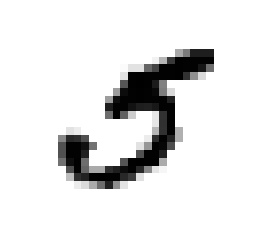

5.0


In [27]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata

from scipy.io import loadmat
# mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
mnist_path = "./mnist-original.mat"
# response = urllib.request.urlopen(mnist_alternative_url)
# with open(mnist_path, "wb") as f:
#     content = response.read()
#     f.write(content)
mnist_raw = loadmat(mnist_path)
mnist = {
    "data": mnist_raw["data"].T,
    "target": mnist_raw["label"][0],
    "COL_NAMES": ["label", "data"],
    "DESCR": "mldata.org dataset: mnist-original",
}
print("Success!")

print(mnist)
X, y = mnist["data"], mnist["target"]
print(X,y)
X.shape, y.shape

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

print(y[36000])
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier

We will simplify the problem and only try to identify one digit at a time for eg 5. This '5-detector' will be and example of a binary classifier.

In [28]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [29]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([False])

## Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor.

>Measuring accuracy using Cross Validation

the cross_val_score() function to evaluate your SGDClassifier model using K-fold crossvalidation,
with three folds. 

In [30]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9652, 0.959 , 0.9528])

Do you think this accuracy number is good? Let try a fit a model which predicts that "no image is 5"

In [31]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90945, 0.9093 , 0.9102 ])

As we can see that even this has high accuracy, that means the dataset is skewed.

In [32]:
# print(len(y_train_5), sum(y_train_5))
# (60000,5421) That means less than 10% is 5

This demonstrates why accuracy is generally not the preferred performance measure for classifiers,
especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent
than others).

### Confusion Matrix https://en.wikipedia.org/wiki/Confusion_matrix

In [33]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53696,   883],
       [ 1577,  3844]], dtype=int64)

+ Precision (Accuracy of the positive prediction) : TP / (TP + FP)
    * A trivial way to have perfect precision is to make a single (1/1 = 100%) prediction and to ensure it is correct. This is not that helpfule So precision is used with another metric.
+ Recall (Sensitivty / True Positive Rate) : TP / (TP + FN)
    * Which is the ratio of positive instances that are correctly detected by the classifier.

In [35]:
from sklearn.metrics import precision_score, recall_score
print("Precision ", precision_score(y_train_5, y_train_pred))
print("Recall ", recall_score(y_train_5, y_train_pred))
from sklearn.metrics import f1_score
print("F1 Score ", f1_score(y_train_5, y_train_pred))

('Precision ', 0.813200761582399)
('Recall ', 0.7090942630510976)
('F1 Score ', 0.7575877020102483)


Precision Recall Tradeoff : Increasing the threshold increases the precision but decreases the recall. Decreasing the threshold increases the recall but decreases the precision. So Looking at the precision recall curve we will choose the best ones.

![](precision_recall_tradeoff2.png)

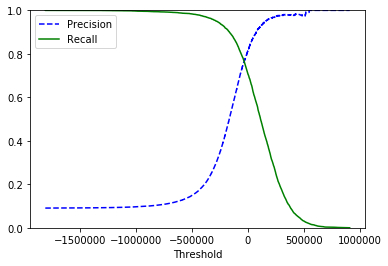

In [36]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [37]:
y_train_pred_90 = (y_scores > 90000)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9137665537419156
0.5473159933591588


> If someone says lets achieve 99% Precision, You ask at what precision?

## The ROC Curve
The receiver operating curve is a common used with binary classifier. It is very similar to the precision / recall curve, but instead of plotting precision versus recall, the ROC plot true positive rate against the false positive rate. False positive rate is the ratio of negative instances that are incorrectly classified as positive. Also, It is equal to 1 - True Negative Rate. TNR is also specificity. Hence ROC plot sensitivity (recall / TPR) vs 1 - specificity( 1 - TNR).

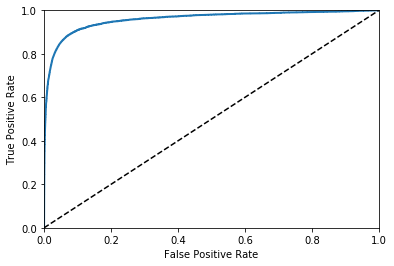

In [38]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

Once again there is Tradeoff, The higher the recall (TPR), the more False Positives (FPR) the classifier produces. The dotted line represents the ROC of a purely random classifier. A good classifier stays as far away from the dotted line. Towards the top left corner.
One way to compare the classifiers is to use, Area under the curve (AUC). A perfect Classifier will have a aread under the curvee equal to 1. whereas a completely random will have it as 0.5

In [39]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9588544783874475

#### Tip: Since the ROC curve is similar to the Precision/Recall curve. How do we decide which ones to use?
+ As a rule of thumb, You should prefer the PR Curve whenever the positive class is rare or when you care more about the false positive than false negatives, and the ROC Curve Otherwise. 


In [40]:
#Comparing RandomForestClassifier and SGDClassifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")
y_probas_forest

array([[1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [0.5, 0.5]])

0.9919197917777892


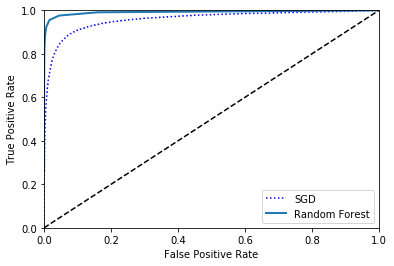

In [42]:
y_scores_forest = y_probas_forest[:,1] # score = proba of positive class
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)
print(roc_auc_score(y_train_5, y_scores_forest))
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()